# Introduction to Python and Natural Language Technologies

__Laboratory 09, Transformers__

__April 14, 2020__

The starter code in this notebook is the same as in Assignment 8. The number of training epochs is increased.

Your task is to replace the model with a Transformer.

Transformer is known to perform worse than LSTMs on small datasets so do not be alarmed when you see a drop in performance.

If you successfully solved Assignment 8, you may start by replacing the starter code with your implementation.

Passing level: Task 1, 2

Extra level: Task 3, 4

## Task 1 - Replace LSTMClassifier with a Transformer-based encoder without positional encoding and attention masking.

We suggest reading this [tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html) first.
The tutorial is for a sequence-to-sequence model which can be easily adapted to sequence classification.
You can use the first output of the Transformer as the representation of the full word.

Make sure that the Transformer parameters are not hardwired.

Don't forget to rename the class since it's no longer an 'LSTM' classifier.

Try out a few options for the Transformer parameters and summarize your findings in a few sentences in the following cell.

##CODE: TASK 1:

In [218]:


class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, output_size, dropout=0.5):
      super(TransformerModel, self).__init__()
      from torch.nn import TransformerEncoder, TransformerEncoderLayer
        
      encoder_layers = TransformerEncoderLayer(d_model=ninp, nhead=nhead, dim_feedforward=nhid, dropout =dropout)
      self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)

      self.encoder = nn.Embedding(ntoken, ninp)
      self.ninp = ninp

      self.decoder = nn.Linear(ninp, output_size)
      

      self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):

      src = self.encoder(src)
      print(f'src.shape ={src.shape}')
      output = self.transformer_encoder(src)
      output = self.decoder(output)
      final_output= F.log_softmax(output, dim=-1) 
      return final_output[:,0,:]

In [ ]:
'''
input_size = len(vocab)
embedding_size = 30
hidden_size = 64
output_size = train_df.label.nunique()

model = LSTMClassifier(input_size, embedding_size, hidden_size, output_size)
model
'''

In [219]:
ntokens = len(vocab) # the size of vocabulary
nip = 60 # embedding dimension = nip = embed_size = d_model
nhid = 64 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
output_size= train_df.label.nunique()
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers,output_size, dropout)

**TESTING THE MODEL FOR TUNING:**

In [217]:
m = nn.LogSoftmax()
#output = m(input)

# check the dimension output: For tuning (changing) the sequence-to-sequence task to normal classification of the sequence task
# batch_size = 128
c=1
for X_batch, seqlen_batch, y_batch in train_iter.iterate_once():
        if c==1:
          y_out = model(X_batch)

          #t= y_out.view(-1, ntokens)
          #print(t)
          #print(t.shape)
          #print(y_out)
          print(y_out.shape)
          print(type(y_out))
          #print(m(y_out))
          #print(y_out[0][0])
        else:
          break
# output shape [batch_size, sequence_len, vocab size] => 1 token in the sequence is a vector of length 40 (= ntoken= vocab size)

src.shape =torch.Size([128, 48, 60])
torch.Size([128, 48, 3])
<class 'torch.Tensor'>
src.shape =torch.Size([128, 48, 60])
torch.Size([128, 48, 3])
<class 'torch.Tensor'>
src.shape =torch.Size([128, 48, 60])
torch.Size([128, 48, 3])
<class 'torch.Tensor'>
src.shape =torch.Size([128, 48, 60])
torch.Size([128, 48, 3])
<class 'torch.Tensor'>
src.shape =torch.Size([128, 48, 60])
torch.Size([128, 48, 3])
<class 'torch.Tensor'>
src.shape =torch.Size([128, 48, 60])
torch.Size([128, 48, 3])
<class 'torch.Tensor'>
src.shape =torch.Size([128, 48, 60])
torch.Size([128, 48, 3])
<class 'torch.Tensor'>
src.shape =torch.Size([104, 48, 60])
torch.Size([104, 48, 3])
<class 'torch.Tensor'>


## Task 2 - Positional encoding

Add positional encoding to the Transformer. 
You can take inspiration from Lecture 9.

Make the base of the positional encoding (10000) by default configurable.

Try out a few options and summarize your findings in the following cell.

YOUR ANSWER HERE

## Task 3 - Attention masking

The Transformer does not need to put any attention weight on PAD symbols.
This can be done by supplying a mask to `TransformerEncoder`.

Add this mask and summarize your findings in the following cell.

YOUR ANSWER HERE

## Task 4 - Training improvement

Transformers are notoriously hard to train.

Try to improve the training process.
Here is an incomplete list of tricks that may improve the training process:
- learning rate decay
- different initialization
- warm up.

You are encouraged to find further tricks.

Try at least two tricks and summarize your findings. It does not matter if they do not improve the accuracy of the classifier.

YOUR ANSWER HERE

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim

# Cloning the data repository

In [3]:
language = "hun"
unimorph_path = f"data/unimorph_{language}/"
pipe = subprocess.Popen(f"git clone https://github.com/unimorph/hun.git {unimorph_path}",
                        shell=True, stderr=subprocess.PIPE, stdout=subprocess.PIPE)
stdout, stderr = pipe.communicate()
print(stdout.decode('utf8'))
print(stderr.decode('utf8'))


Cloning into 'data/unimorph_hun'...



# Data loading

In [4]:
data = pd.read_table(f"{unimorph_path}/{language}", names=['lemma', 'infl', 'tags'], skip_blank_lines=True)

# Target extraction

In [5]:
def extract_target(tags_str):
    """Extracts target if present, returns None otherwise."""
    tags = tags_str.split(";")
    if tags[0] != 'V':
        return None
    if len(tags) < 6:
        return None
    return tags[1]
 
data['target'] = data.tags.apply(extract_target)

In [6]:
data = data[data.target.notnull()]

In [7]:
data['target'].value_counts()

IND     42784
COND    21036
SBJV    20986
Name: target, dtype: int64

# Train/dev/test set creation

We avoid lemma overlaps between the splits.

In [8]:
lemmas = data.lemma.unique()
len(lemmas), type(lemmas)

(2109, numpy.ndarray)

In [9]:
np.random.seed(12)
np.random.shuffle(lemmas)
train_size = int(0.8 * len(lemmas))
dev_size = int(0.1 * len(lemmas))
train_lemmas = lemmas[:train_size]
dev_lemmas = lemmas[train_size:train_size+dev_size]
test_lemmas = lemmas[train_size+dev_size:]

train_lemmas = set(train_lemmas)
dev_lemmas = set(dev_lemmas)
test_lemmas = set(test_lemmas)

In [10]:
train_df = data[data.lemma.isin(train_lemmas)]
dev_df = data[data.lemma.isin(dev_lemmas)]
test_df = data[data.lemma.isin(test_lemmas)]
len(train_df), len(dev_df), len(test_df)

(67665, 8447, 8694)

In [11]:
train_df = train_df.sample(1000, random_state=1).reset_index(drop=True)
dev_df = dev_df.sample(200, random_state=1).reset_index(drop=True)
test_df = test_df.sample(200, random_state=1).reset_index(drop=True)

# Preprocessing

In [12]:
alphabet = set()
for token in train_df.infl:
    alphabet |= set(token)
len(alphabet)

36

In [13]:
alphabet.add('<PAD>')
alphabet.add('<BOS>')
alphabet.add('<EOS>')
alphabet.add('<UNK>')

In [14]:
vocab = {symbol: i for i, symbol in enumerate(alphabet)}
len(vocab)

40

In [16]:
def encode_token(token):
    ids = []
    ids.append(vocab['<BOS>'])
    # dev and test might contain characters outside the alphabet
    ids.extend(vocab.get(c, vocab['<UNK>']) for c in token)
    ids.append(vocab['<EOS>'])
    return ids

print(f"encode_token('alma')= {encode_token('alma')}")
print(f"vocab['<UNK>'] ={vocab['<UNK>']}")
print(f"encode_token('ALMA') = {encode_token('ALMA')}")

encode_token('alma')= [23, 28, 21, 38, 28, 4]
vocab['<UNK>'] =15
encode_token('ALMA') = [23, 15, 15, 15, 15, 4]


In [17]:
train_df['encoded'] = train_df.infl.apply(encode_token)
dev_df['encoded'] = dev_df.infl.apply(encode_token)
test_df['encoded'] = test_df.infl.apply(encode_token)
train_df.head()

,lemma,infl,tags,target,encoded
0,kiemelkedik,kiemelkedtek,V;IND;PST;INDF;3;PL,IND,"[23, 17, 5, 32, 38, 32, 21, 17, 32, 10, 6, 32,..."
1,elkényeztet,elkényeztette,V;IND;PST;DEF;3;SG,IND,"[23, 32, 21, 17, 11, 9, 39, 32, 34, 6, 32, 6, ..."
2,latol,latolják,V;SBJV;PRS;DEF;3;PL,SBJV,"[23, 21, 28, 6, 8, 21, 36, 26, 17, 4]"
3,vizionál,vizionáltunk,V;IND;PST;INDF;1;PL,IND,"[23, 13, 5, 34, 5, 8, 9, 26, 21, 6, 7, 9, 17, 4]"
4,felkér,felkér,V;IND;PRS;INDF;3;SG,IND,"[23, 3, 32, 21, 17, 11, 35, 4]"


In [18]:
maxlen = train_df.encoded.apply(len).max()
print(maxlen)

def pad_sequence(sequence):
    if len(sequence) > maxlen:
        return sequence[:maxlen]
    return sequence + [vocab['<PAD>'] for _ in range(maxlen-len(sequence))]

print(pad_sequence([1, 2, 3]))

48
[1, 2, 3, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25]


In [19]:
train_df['padded'] = train_df.encoded.apply(pad_sequence)
dev_df['padded'] = dev_df.encoded.apply(pad_sequence)
test_df['padded'] = test_df.encoded.apply(pad_sequence)

train_df['padded'].apply(len).value_counts()

48    1000
Name: padded, dtype: int64

In [21]:
train_df['seqlen'] = train_df.encoded.apply(len)
dev_df['seqlen'] = dev_df.encoded.apply(len)
test_df['seqlen'] = test_df.encoded.apply(len)

In [22]:
label_to_id = {label: i for i, label in enumerate(train_df.target.unique())}
label_to_id

{'COND': 2, 'IND': 0, 'SBJV': 1}

In [23]:
train_df['label'] = train_df.target.apply(lambda c: label_to_id[c])
dev_df['label'] = dev_df.target.apply(lambda c: label_to_id[c])
test_df['label'] = test_df.target.apply(lambda c: label_to_id[c])

# Creating tensors

In [25]:
X_train = torch.from_numpy(np.array(list(train_df.padded)))
y_train = torch.LongTensor(train_df.label.values)
seqlen_train = torch.LongTensor(train_df.seqlen.values)
print(f"X_train.size() = {X_train.size()},\ny_train.size() ={y_train.size()}\nseqlen_train.size() = {seqlen_train.size()}\n")

X_dev = torch.from_numpy(np.array(list(dev_df.padded)))
y_dev = torch.LongTensor(dev_df.label.values)
seqlen_dev = torch.LongTensor(dev_df.seqlen.values)
print(f"X_dev.size() = {X_dev.size()},\ny_dev.size() = {y_dev.size()}\nseqlen_dev.size() = {seqlen_dev.size()}\n")

X_test = torch.from_numpy(np.array(list(test_df.padded)))
y_test = torch.LongTensor(test_df.label.values)
seqlen_test = torch.LongTensor(test_df.seqlen.values)
print(f"X_test.size() = {X_test.size()},\ny_test.size() ={y_test.size()}\nseqlen_test.size() = {seqlen_test.size()}")

X_train.size() = torch.Size([1000, 48]),
y_train.size() =torch.Size([1000])
seqlen_train.size() = torch.Size([1000])

X_dev.size() = torch.Size([200, 48]),
y_dev.size() = torch.Size([200])
seqlen_dev.size() = torch.Size([200])

X_test.size() = torch.Size([200, 48]),
y_test.size() =torch.Size([200])
seqlen_test.size() = torch.Size([200])


# Model

In [200]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
        )
        self.dense = nn.Linear(hidden_size * 2, output_size)
        
    # the input signature of forward changes
    def forward(self, sequences, sequence_lens):
        embedded = self.embedding(sequences)
        
        # THIS IS THE MODIFIED PART
        # returns a PackedSequence object
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded,
            sequence_lens,
            enforce_sorted=False,
            batch_first=True)
        packed_outputs, (h, c) = self.lstm(packed)
        # extract LSTM outputs (not used here)
        lstm_outputs, lens = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        
        h = torch.cat((h[0], h[1]), dim=-1)
        output = self.dense(h)
        return output

In [201]:
input_size = len(vocab)
embedding_size = 30
hidden_size = 64
output_size = train_df.label.nunique()

model = LSTMClassifier(input_size, embedding_size, hidden_size, output_size)
model
print(output_size)

3


# Batching

In [202]:
class BatchedIterator:
    def __init__(self, *tensors, batch_size):
        # all tensors must have the same first dimension
        assert len(set(len(tensor) for tensor in tensors)) == 1
        self.tensors = tensors
        self.batch_size = batch_size
    
    def iterate_once(self):
        num_data = len(self.tensors[0])
        for start in range(0, num_data, self.batch_size):
            end = start + self.batch_size
            yield tuple(tensor[start:end] for tensor in self.tensors)

# Training

In [220]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [221]:
num_epochs = 50
batch_size = 128

metrics = defaultdict(list)
train_iter = BatchedIterator(X_train, seqlen_train, y_train, batch_size=batch_size)

In [222]:
for epoch in range(num_epochs):
    model.train()
    # Training loop
  
    for X_batch, seqlen_batch, y_batch in train_iter.iterate_once():
        #y_out = model(X_batch, seqlen_batch)

        # FOR TASK 1:
        
        y_out = model(X_batch)
        # FOR TASK 1:
        
        # To understand the ouput of the model:
        # y_out.shape = [batch_size, output_size] # output_size = number of labels
        #print(f'y_out.shape= {y_out.shape} \ny_batch.shape= {y_batch.shape} ')

        #print(f'y_out.shape= {y_out.shape} \ny_batch.shape= {y_batch.shape} ')
        loss = criterion(y_out, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.eval()  # or model.train(False)
    # Train and dev loss at the end of the epoch
    #FOR BEGINING (TESTING BEFORE RUNNING TASK 1)
    #y_out = model(X_train, seqlen_train)
    #FOR BEGINING (TESTING BEFORE RUNNING TASK 1)

    # FOR TASK 1:
    y_out = model(X_train)
    # FOR TASK 1:

    train_loss = criterion(y_out, y_train).item()
    metrics['train_loss'].append(train_loss)
    labels = y_out.argmax(axis=1)
    train_accuracy = (torch.eq(y_train, labels).sum() / float(labels.size(0))).item()
    metrics['train_accuracy'].append(train_accuracy)
    
    #FOR BEGINING (TESTING BEFORE RUNNING TASK 1)
    #y_out = model(X_dev, seqlen_dev)
    #FOR BEGINING (TESTING BEFORE RUNNING TASK 1)
    # FOR TASK 1:
    y_out = model(X_dev)
    # FOR TASK 1:

    dev_loss = criterion(y_out, y_dev).item()
    metrics['dev_loss'].append(dev_loss)
    labels = y_out.argmax(axis=1)
    dev_accuracy = (torch.eq(y_dev, labels).sum() / float(labels.size(0))).item()
    metrics['dev_accuracy'].append(dev_accuracy)
    
    print(f"Epoch: {epoch} -- train loss: {train_loss:.3f} - train acc: {train_accuracy:.1%} - "
          f"dev loss: {dev_loss:.3f} - dev acc: {dev_accuracy:.1%}")

src.shape =torch.Size([128, 48, 60])
src.shape =torch.Size([128, 48, 60])
src.shape =torch.Size([128, 48, 60])
src.shape =torch.Size([128, 48, 60])
src.shape =torch.Size([128, 48, 60])
src.shape =torch.Size([128, 48, 60])
src.shape =torch.Size([128, 48, 60])
src.shape =torch.Size([104, 48, 60])
src.shape =torch.Size([1000, 48, 60])
src.shape =torch.Size([200, 48, 60])
Epoch: 0 -- train loss: 1.058 - train acc: 49.6% - dev loss: 1.005 - dev acc: 55.0%
src.shape =torch.Size([128, 48, 60])
src.shape =torch.Size([128, 48, 60])
src.shape =torch.Size([128, 48, 60])
src.shape =torch.Size([128, 48, 60])
src.shape =torch.Size([128, 48, 60])
src.shape =torch.Size([128, 48, 60])
src.shape =torch.Size([128, 48, 60])
src.shape =torch.Size([104, 48, 60])
src.shape =torch.Size([1000, 48, 60])
src.shape =torch.Size([200, 48, 60])
Epoch: 1 -- train loss: 1.054 - train acc: 49.6% - dev loss: 1.032 - dev acc: 55.0%
src.shape =torch.Size([128, 48, 60])
src.shape =torch.Size([128, 48, 60])
src.shape =torch

KeyboardInterrupt: ignored

# Evaluation

## Plot the results

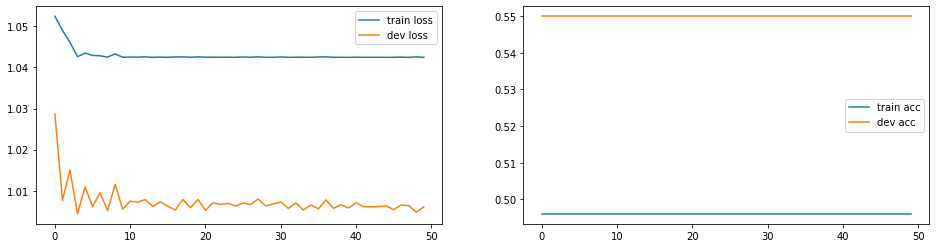

In [181]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.lineplot(data=metrics['train_loss'], ax=ax[0], label='train loss')
sns.lineplot(data=metrics['dev_loss'], ax=ax[0], label='dev loss')

sns.lineplot(data=metrics['train_accuracy'], ax=ax[1], label='train acc')
sns.lineplot(data=metrics['dev_accuracy'], ax=ax[1], label='dev acc')

## Test accuracy

In [33]:
logits = model(X_test, seqlen_test)
test_prediction = logits.argmax(axis=1)
test_accuracy = torch.sum(torch.eq(test_prediction, y_test)) / float(test_prediction.size(0))
print(f"Test accuracy: {test_accuracy:.1%}")

Test accuracy: 95.0%


## Error analysis

In [34]:
test_df['prediction'] = test_prediction

In [35]:
id_to_label = {i: l for l, i in label_to_id.items()}
test_df['predicted_target'] = test_df['prediction'].apply(lambda id_: id_to_label[id_])

In [36]:
incorrect = test_df[test_df.prediction != test_df.label][['infl', 'target', 'predicted_target']]
incorrect.sample(min(len(incorrect), 20))

,infl,target,predicted_target
109,csöpögjön,SBJV,COND
112,lemész|or|,IND,SBJV
24,legyőznek,IND,SBJV
133,ágyazza,SBJV,IND
173,kacagjátok,SBJV,IND
11,vacsorázzuk,SBJV,IND
134,felfrissítették,IND,SBJV
159,kóstolja,IND,SBJV
197,fakasszátok,SBJV,IND
38,stagnáljatok,SBJV,IND
